# Fractional Brownian Motion

In this notebook we let the midprice process follow a fractional Brownian motion. There is no closed-form solution of what the optimal execution strategy is in this case. As we will see, the signature method learns to exploit the memory-effect of fBM.

In [1]:
import notebook_base

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from data.fbm import FBM
from optimal_execution.sig_execution import SigExecution
import optimal_execution.utils

(CVXPY) May 25 02:24:14 PM: Encountered unexpected exception importing solver SCS:
ImportError('libmkl_rt.so.2: cannot open shared object file: No such file or directory')


## Define parameters and simulate paths

We now set the parameters of the parameters of the optimal execution problem.

In [2]:
params = {
    "N": 2,
    "q0": 1.,
    "k":  1e-4,
    "Lambda": 1e-3,
    "alpha": 0.1,
    "phi": 0,
}

We sample from a fBM with a given Hurst parameter H.

In [3]:
H = 1/3.
process = FBM(H=H)
paths, ES = process.build(n_paths=50000, order=2 * (params["N"] + 1) + 1)

Building paths:   0%|          | 0/50000 [00:00<?, ?it/s]

Computing signatures:   0%|          | 0/50000 [00:00<?, ?it/s]

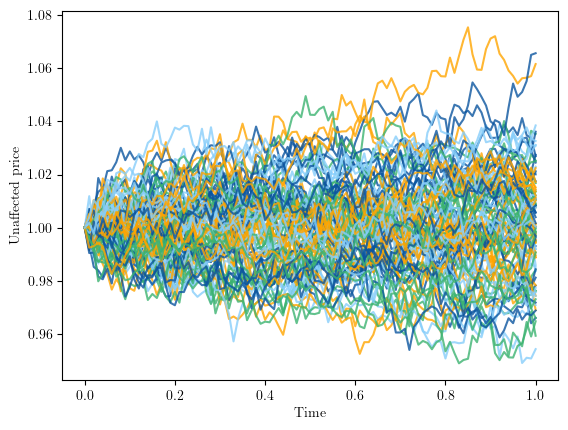

In [4]:
plt.plot(*paths[:100].T, alpha=0.8)
plt.xlabel("Time")
plt.ylabel("Unaffected price")
plt.show()

## Fit the linear functional $\ell$

1. Initialise SigExecution class
2. Fit (we see that this is very fast)

In [5]:
SE = SigExecution(ES, **params);

In [6]:
SE.fit()
l = SE.l.value

  0%|          | 0/7 [00:00<?, ?it/s]

## Analysis

In [17]:
sample = paths[:100]

speeds, inventory, wealths = SE.get_analytics(sample, phi=0)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Observe that the signature strategy speculates on the asset by leveraging the memory effect of fractional Brownian motions.

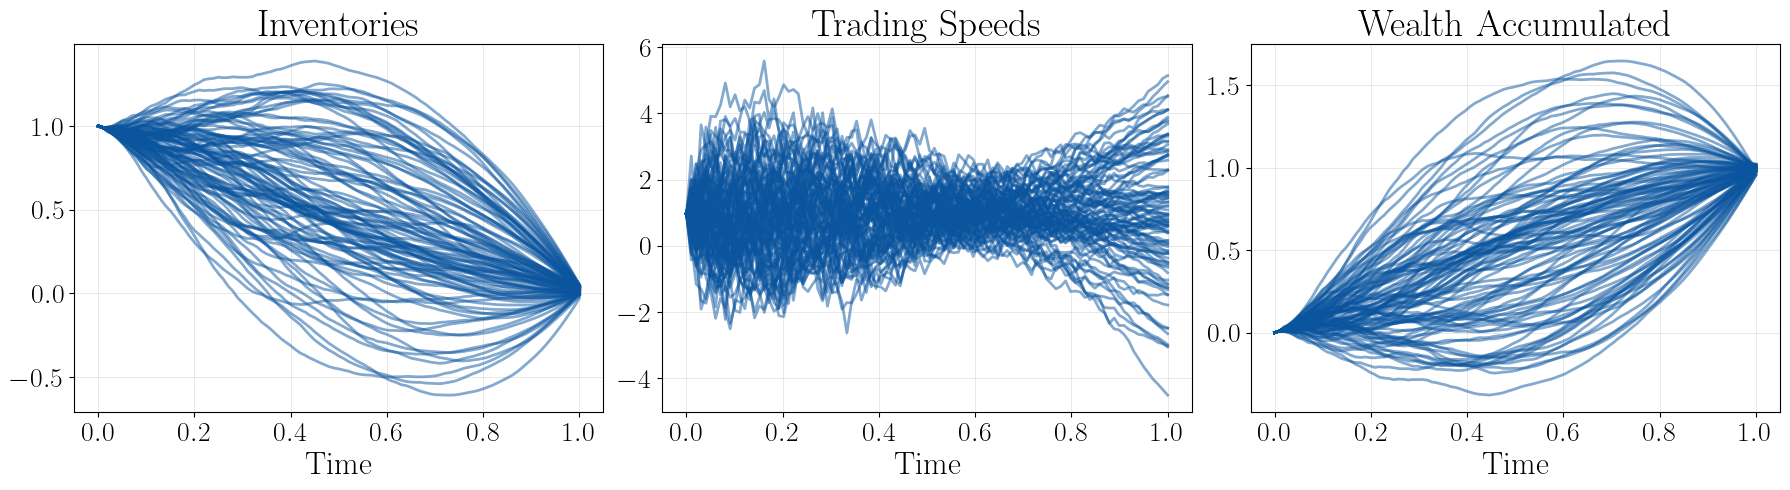

In [19]:
fig, ax = plt.subplots(1,3,figsize=(18,5))

for Q in inventory:    
    ax[0].plot(np.linspace(0, 1, len(Q)), Q, alpha=0.5, lw=2, color=sns.color_palette("Blues")[5])
ax[0].set_title("Inventories", fontsize=27)

for theta in speeds:    
    ax[1].plot(np.linspace(0, 1, len(theta)), theta, alpha=0.5, lw=2, color=sns.color_palette("Blues")[5])
ax[1].set_title("Trading Speeds", fontsize=27)
# ax[1].set_ylim(0., 2.)

for w in wealths:    
    ax[2].plot(np.linspace(0, 1, len(w)), w, alpha=0.5, lw=2, color=sns.color_palette("Blues")[5])
ax[2].set_title("Wealth Accumulated", fontsize=27)

for i in range(3):
    ax[i].set_xlabel("Time", fontsize=14)
    ax[i].yaxis.label.set_size(23)
    ax[i].xaxis.label.set_size(23)
    ax[i].tick_params(axis='x', labelsize=20)
    ax[i].tick_params(axis='y', labelsize=20)
    # ax[i].legend(fontsize=20)
    ax[i].grid(alpha=0.4, linewidth=.5)

fig.tight_layout()


# Changing $\phi$

Here we explore the effect of changing the "urgency term" $\phi$. As $\phi$ is increased, the inventory will decay faster as holding inventory for long periods is penalised. We will solve the optimal execution problem with signatures for different values of $\phi$.

In [9]:
phis = [0, 0.001, 0.005, 0.01]
inventories_phi = []
speeds_phi = []
pnls_phi = []
for phi in phis:
    l = SE.fit(phi)
    speeds, inventories, pnls = SE.get_analytics(paths[:2000])
    
    inventories_phi.append(inventories)
    speeds_phi.append(speeds)
    pnls_phi.append(pnls)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

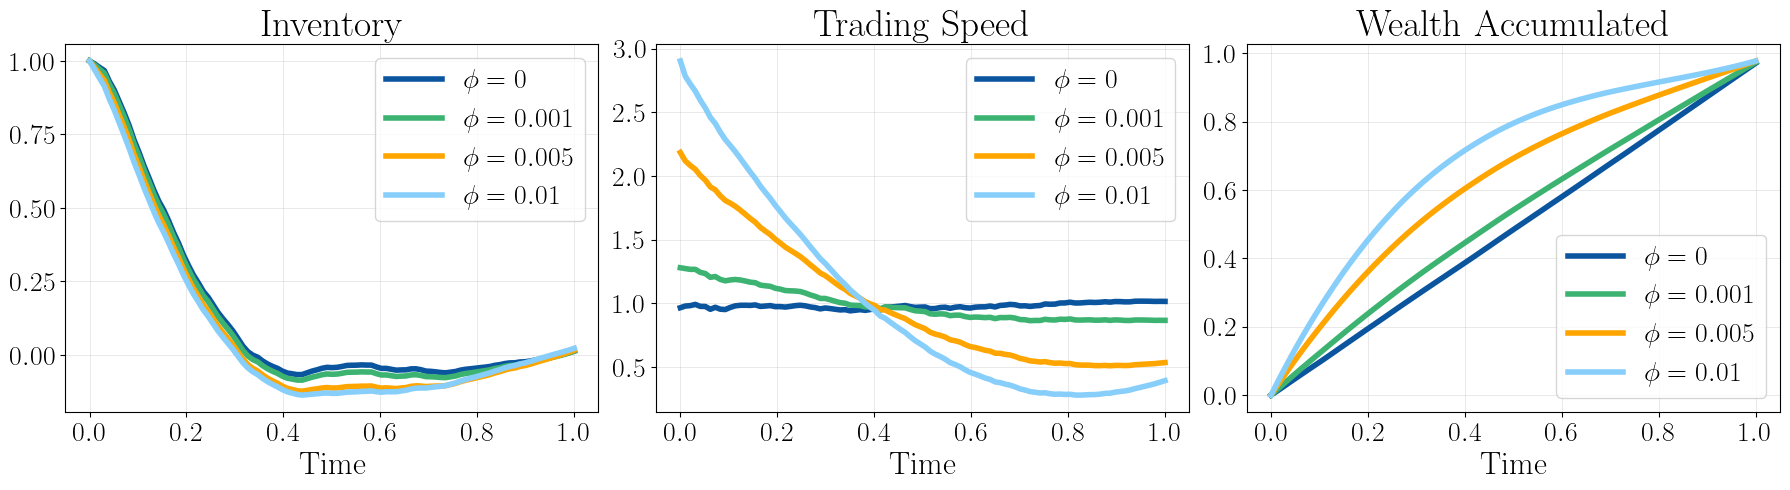

In [10]:
fig, ax = plt.subplots(1,3,figsize=(18,5))

for inventory, phi in zip(inventories_phi, phis):
    for Q in inventory[:1]:
        Q = Q[:-2]
        ax[0].plot(np.linspace(0, 1, len(Q)), Q, alpha=1., label=r"$\phi={}$".format(phi), lw=4)
ax[0].set_title("Inventory", fontsize=27)

for speed, phi in zip(speeds_phi, phis):
    theta = np.stack(speed, axis=-1).mean(axis=1)
    theta = theta[:-2]
    ax[1].plot(np.linspace(0, 1, len(theta)), theta, alpha=1., label=r"$\phi={}$".format(phi), lw=4)
ax[1].set_title("Trading Speed", fontsize=27)

for pnl, phi in zip(pnls_phi, phis):
    wealth = np.stack(pnl, axis=-1).mean(axis=1)
    wealth = wealth[:-2]
    ax[2].plot(np.linspace(0, 1, len(wealth)), wealth, alpha=1., label=r"$\phi={}$".format(phi), lw=4)
ax[2].set_title("Wealth Accumulated", fontsize=27)

for i in range(3):
    ax[i].set_xlabel("Time", fontsize=14)
    ax[i].yaxis.label.set_size(23)
    ax[i].xaxis.label.set_size(23)
    ax[i].tick_params(axis='x', labelsize=20)
    ax[i].tick_params(axis='y', labelsize=20)
    ax[i].legend(fontsize=20)
    ax[i].grid(alpha=0.4, linewidth=.5)

fig.tight_layout()


#### What happens if we liquidated our whole position at each time? For $\phi=0$

i.e this shows us what our current portfolio value is:
-  the cash we have accumulated + current liquidation value - impact

In [20]:
invs = np.stack(inventory)
naive_speeds = invs * sample.shape[1] # if we liquidate all remaining inventory at once
perm_ims = params["k"] * invs # permanent impact
temp_ims = params["Lambda"] * naive_speeds # temporary impact where sig-speed = 
naive_execution_val = (sample[:,:,1] - perm_ims - temp_ims) * invs
cash_accum = np.stack(wealths)[:,:-1]
naive_wealth = naive_execution_val + cash_accum

Why we need to trade slowly!

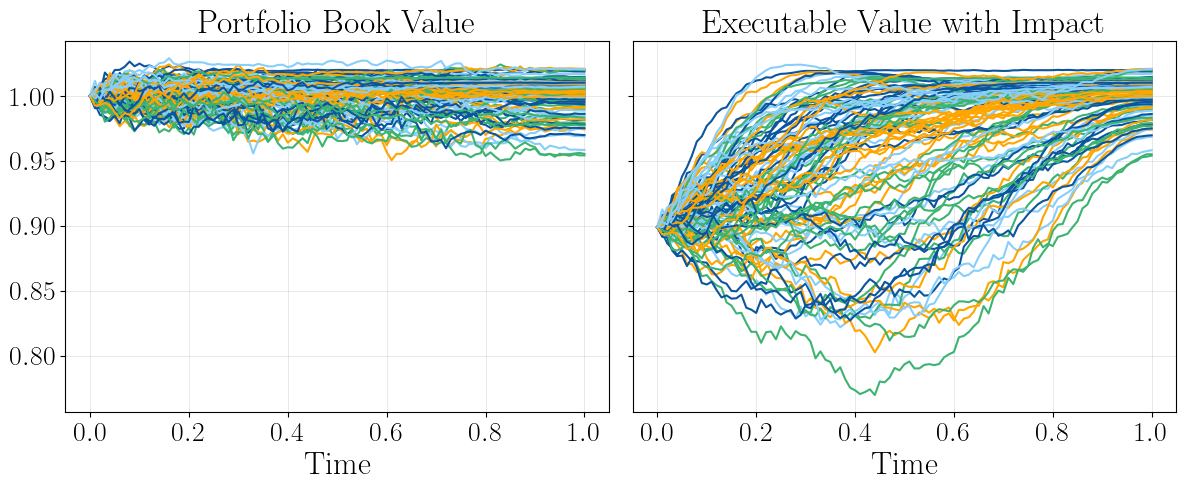

In [21]:
fig, ax = plt.subplots(1,2,figsize=(12,5), sharey=True)
ax[0].plot(np.linspace(0, 1, cash_accum.shape[-1]), (cash_accum+ invs*(sample[:,:,1])).T);
ax[0].set_title("Portfolio Book Value", fontsize=24)
ax[1].plot(np.linspace(0, 1, cash_accum.shape[-1]),naive_wealth.T);
ax[1].set_title("Executable Value with Impact", fontsize=24)

for i in range(2):
    ax[i].set_xlabel("Time", fontsize=14)
    ax[i].yaxis.label.set_size(23)
    ax[i].xaxis.label.set_size(23)
    ax[i].tick_params(axis='x', labelsize=20)
    ax[i].tick_params(axis='y', labelsize=20)
    ax[i].grid(alpha=0.4, linewidth=.5)

fig.tight_layout()